In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set seed for reproducibility
np.random.seed(42)

# 1. Bandit Environment
class Bandit:
    def __init__(self, k=10):
        self.k = k
        # True means drawn from standard normal N(0,1)
        self.q = np.random.normal(0, 1, k)
        self.opt_arm = np.argmax(self.q)

    def pull(self, a, n):
        # Vectorized pull: mean of n samples from N(q[a], 1.0)
        return np.mean(np.random.normal(self.q[a], 1.0, int(n)))

# 2. Naive PAC Algorithm
def naive_pac(env, eps, delta):
    k = env.k
    # Exact formula from mea.cpp
    n_pulls = int(np.ceil((2.0 / (eps * eps)) * np.log((2.0 * k) / delta)))
    
    est = np.zeros(k)
    for a in range(k):
        est[a] = env.pull(a, n_pulls)
        
    best_arm = np.argmax(est)
    total_pulls = k * n_pulls
    
    return best_arm == env.opt_arm, total_pulls

# 3. Median Elimination Algorithm (MEA)
def median_elim(env, eps, delta):
    S = list(range(env.k))
    e = eps / 4.0
    d = delta / 2.0
    total_pulls = 0

    while len(S) > 1:
        n_l = int(np.ceil((1.0 / (2 * e * e)) * np.log(3.0 / d)))
        
        empirical_means = []
        for a in S:
            empirical_means.append(env.pull(a, n_l))
            
        total_pulls += len(S) * n_l
        
        median_val = np.median(empirical_means)
        
        # Keep arms >= median
        next_S = [S[i] for i in range(len(S)) if empirical_means[i] >= median_val]
        
        # Exact edge case handling from mea.cpp: if(nxt.size()==S.size()) nxt.pop_back();
        if len(next_S) == len(S):
            next_S.pop() 
            
        S = next_S
        e *= 0.5
        d *= 0.5

    best_arm = S[0]
    return best_arm == env.opt_arm, total_pulls

In [ ]:
k_arms = 10
runs = 200 
eps_vals = np.round(np.arange(0.1, 1.1, 0.1), 1)
delta_vals = np.round(np.arange(0.1, 1.1, 0.1), 1)


naive_success = np.zeros((len(delta_vals), len(eps_vals)))
mea_success = np.zeros((len(delta_vals), len(eps_vals)))
naive_pulls = np.zeros((len(delta_vals), len(eps_vals)))
mea_pulls = np.zeros((len(delta_vals), len(eps_vals)))

print(f"Running {runs} runs per grid point...")
for i, d in enumerate(tqdm(delta_vals, desc="Delta Progress")):
    for j, e in enumerate(eps_vals):
        s_naive, s_mea = 0, 0
        p_naive, p_mea = 0, 0
        
        for _ in range(runs):
            env = Bandit(k=k_arms)
            
            # Run Naive
            succ_n, pulls_n = naive_pac(env, e, d)
            s_naive += succ_n
            p_naive += pulls_n
            
            # Run MEA
            succ_m, pulls_m = median_elim(env, e, d)
            s_mea += succ_m
            p_mea += pulls_m
            
        # Store Averages
        naive_success[i, j] = s_naive / runs
        mea_success[i, j] = s_mea / runs
        naive_pulls[i, j] = p_naive / runs
        mea_pulls[i, j] = p_mea / runs

print("Simulations complete.")

Running 200 runs per grid point...


Delta Progress: 100%|██████████| 10/10 [01:12<00:00,  7.22s/it]

Simulations complete.


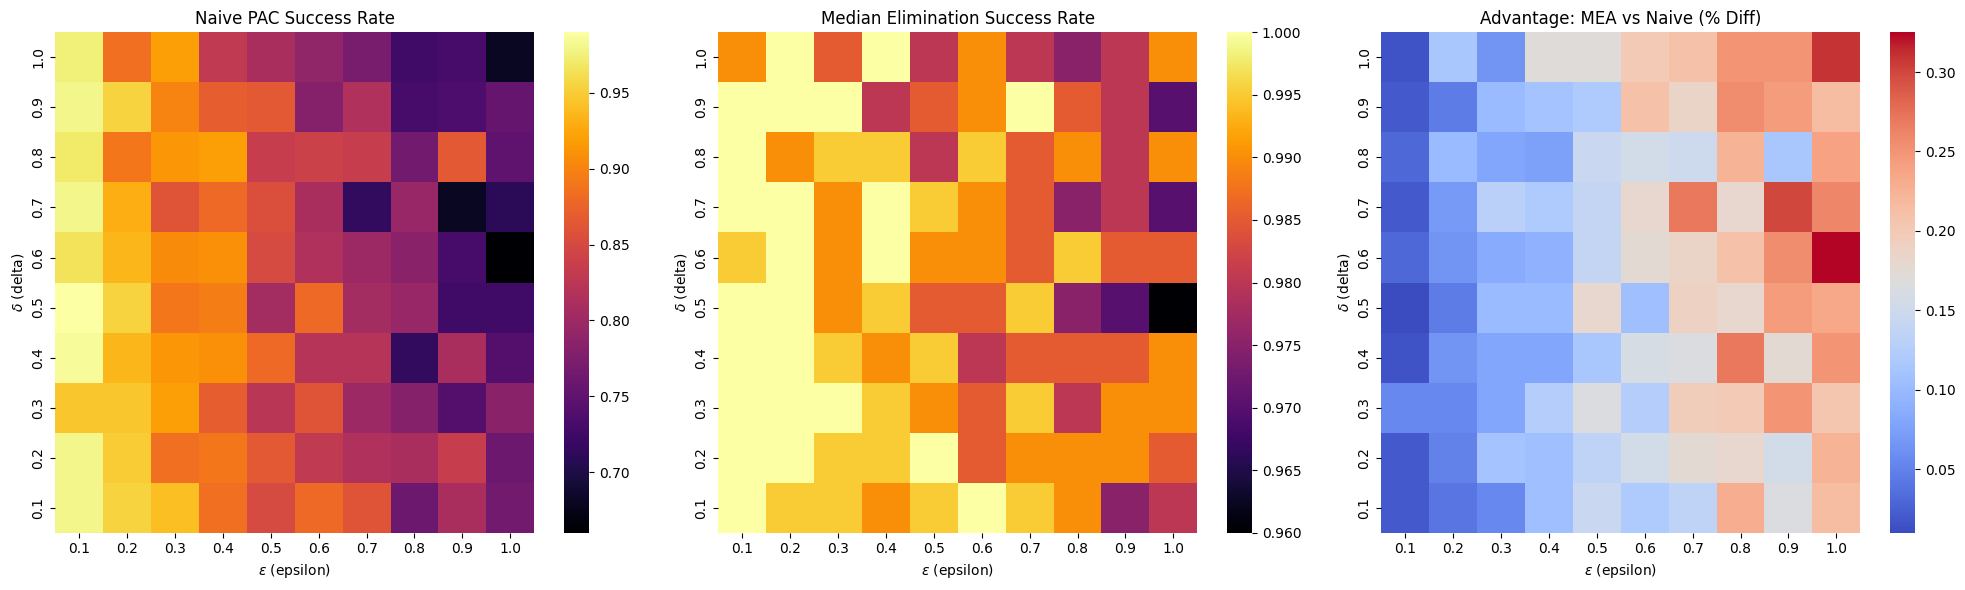

In [19]:
cmap = 'inferno' 
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- PLOT 1: Naive Success Rate ---
sns.heatmap(naive_success, annot=False, cmap=cmap, xticklabels=eps_vals, yticklabels=delta_vals, ax=axes[0])
axes[0].invert_yaxis() # Ensure origin is at bottom left
axes[0].set_title("Naive PAC Success Rate")
axes[0].set_xlabel(r"$\epsilon$ (epsilon)")
axes[0].set_ylabel(r"$\delta$ (delta)")

# --- PLOT 2: MEA Success Rate ---
sns.heatmap(mea_success, annot=False, cmap=cmap, xticklabels=eps_vals, yticklabels=delta_vals, ax=axes[1])
axes[1].invert_yaxis()
axes[1].set_title("Median Elimination Success Rate")
axes[1].set_xlabel(r"$\epsilon$ (epsilon)")
axes[1].set_ylabel(r"$\delta$ (delta)")

# --- PLOT 3: Success Rate Difference (MEA - Naive) ---
sns.heatmap(mea_success - naive_success, annot=False, cmap='coolwarm', xticklabels=eps_vals, yticklabels=delta_vals, ax=axes[2])
axes[2].invert_yaxis()
axes[2].set_title("Advantage: MEA vs Naive (% Diff)")
axes[2].set_xlabel(r"$\epsilon$ (epsilon)")
axes[2].set_ylabel(r"$\delta$ (delta)")

plt.tight_layout()
plt.show()

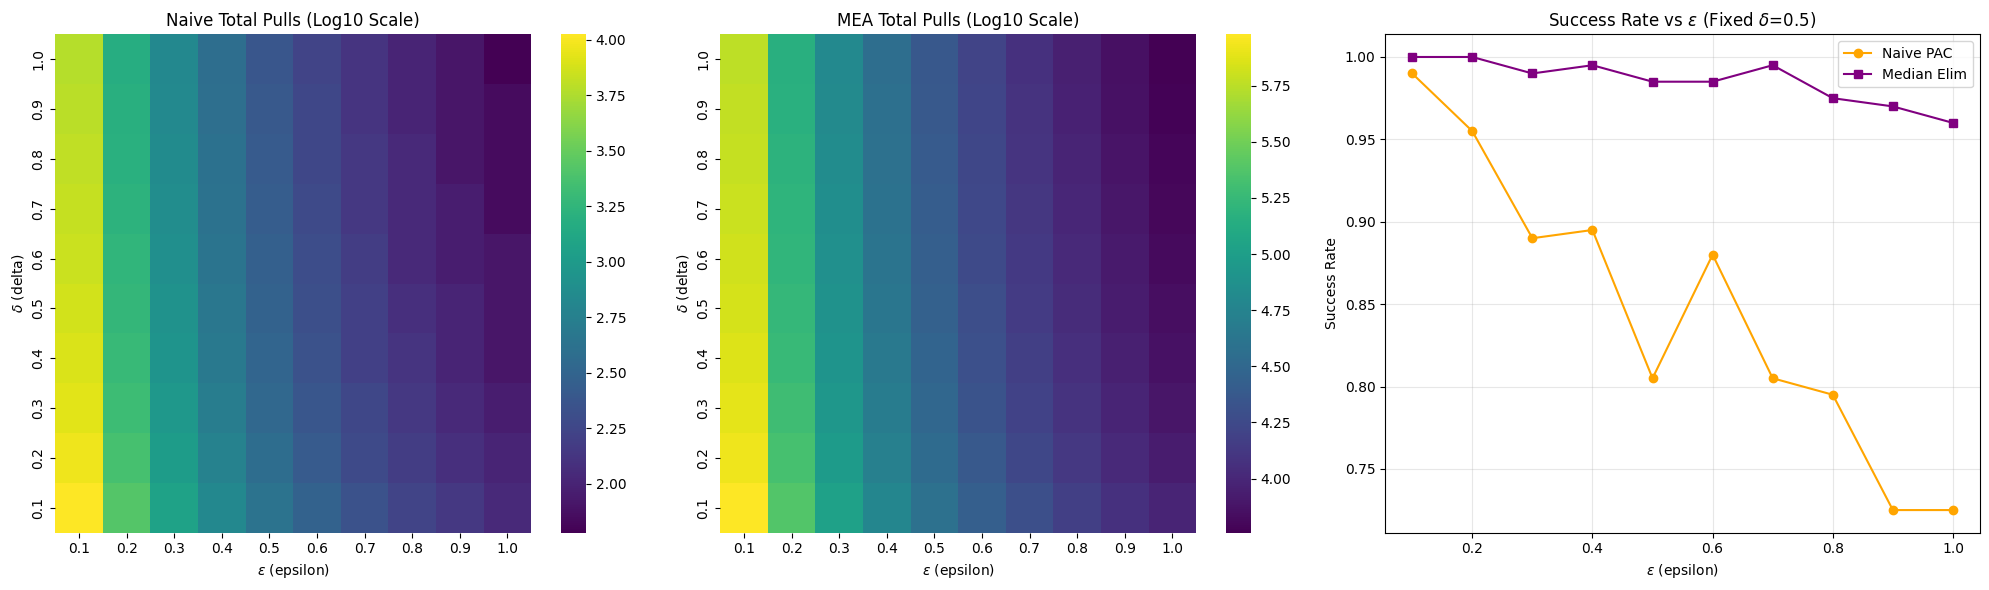

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- PLOT 4: Naive Sample Complexity ---
sns.heatmap(np.log10(naive_pulls), annot=False, cmap='viridis', xticklabels=eps_vals, yticklabels=delta_vals, ax=axes[0])
axes[0].invert_yaxis()
axes[0].set_title("Naive Total Pulls (Log10 Scale)")
axes[0].set_xlabel(r"$\epsilon$ (epsilon)")
axes[0].set_ylabel(r"$\delta$ (delta)")

# --- PLOT 5: MEA Sample Complexity ---
sns.heatmap(np.log10(mea_pulls), annot=False, cmap='viridis', xticklabels=eps_vals, yticklabels=delta_vals, ax=axes[1])
axes[1].invert_yaxis()
axes[1].set_title("MEA Total Pulls (Log10 Scale)")
axes[1].set_xlabel(r"$\epsilon$ (epsilon)")
axes[1].set_ylabel(r"$\delta$ (delta)")

# --- PLOT 6: Line Plot Comparison at fixed delta ---
fixed_delta_idx = 4 # delta = 0.5
axes[2].plot(eps_vals, naive_success[fixed_delta_idx, :], marker='o', label='Naive PAC', color='orange')
axes[2].plot(eps_vals, mea_success[fixed_delta_idx, :], marker='s', label='Median Elim', color='purple')
axes[2].set_title(rf"Success Rate vs $\epsilon$ (Fixed $\delta$={delta_vals[fixed_delta_idx]})")
axes[2].set_xlabel(r"$\epsilon$ (epsilon)")
axes[2].set_ylabel("Success Rate")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<>:65: SyntaxWarning: invalid escape sequence '\d'
<>:65: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Dushyant Yadav\AppData\Local\Temp\ipykernel_70300\1892668045.py:65: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'Direct Sample Complexity Comparison (Fixed $\delta$={delta_vals[fixed_d_idx]})')


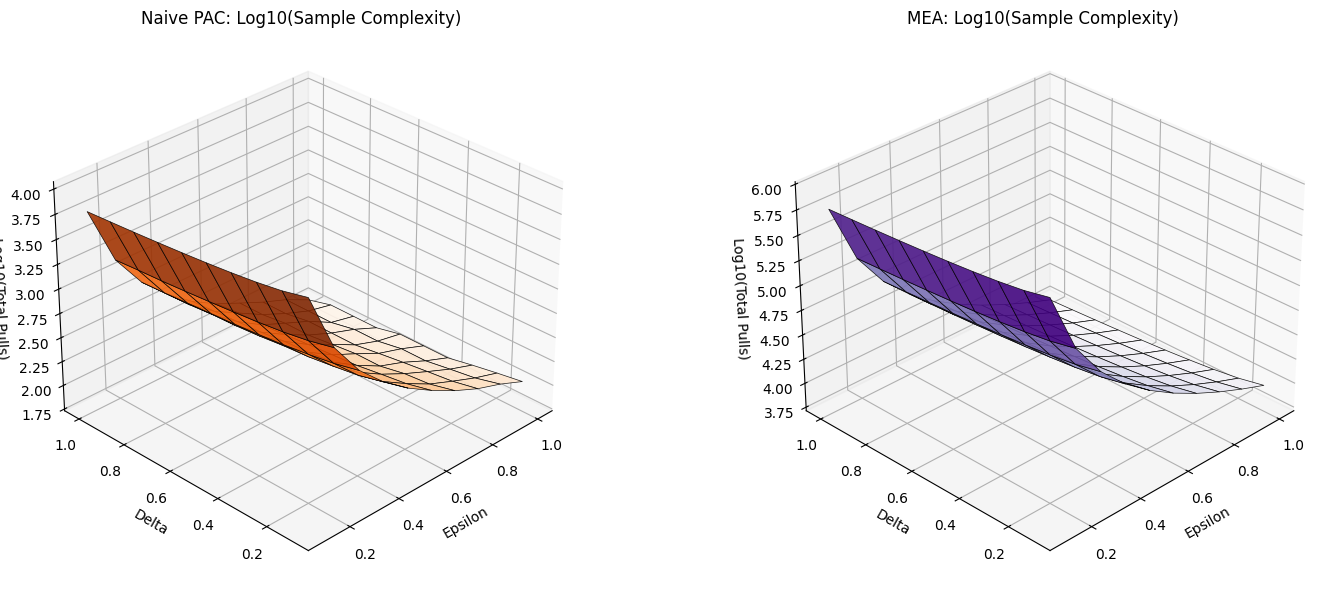

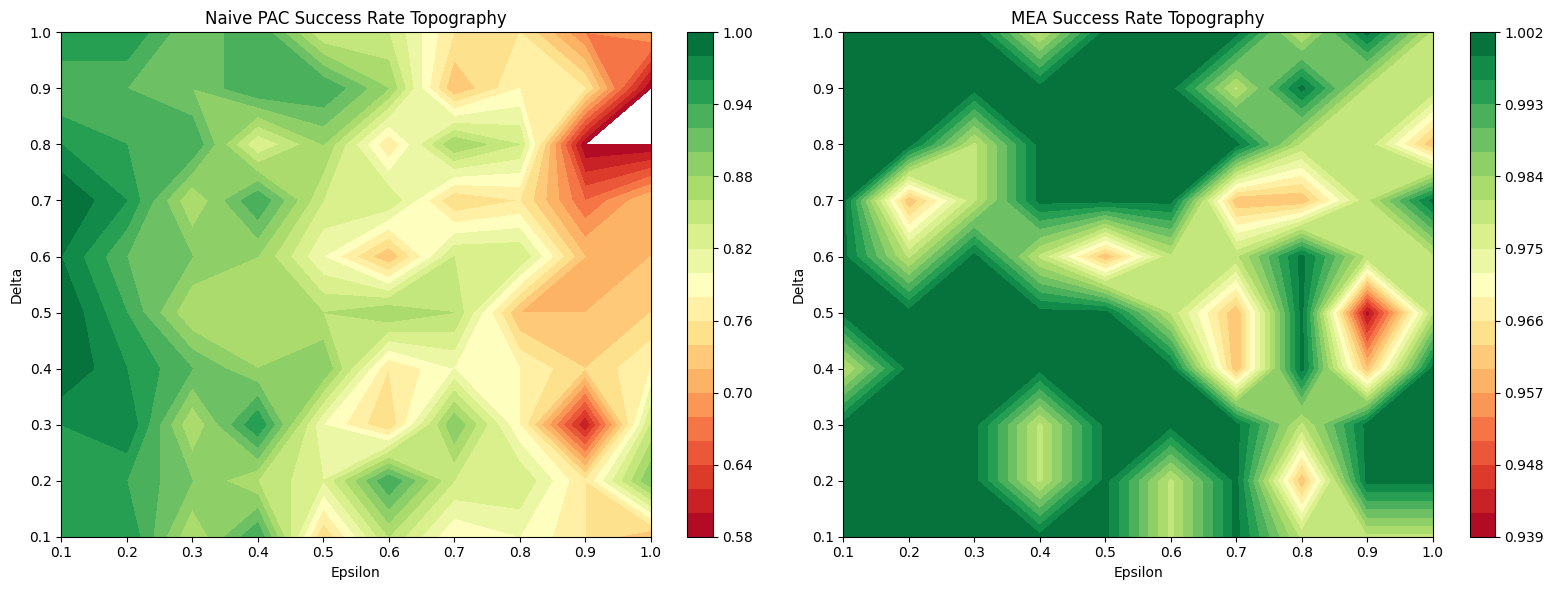

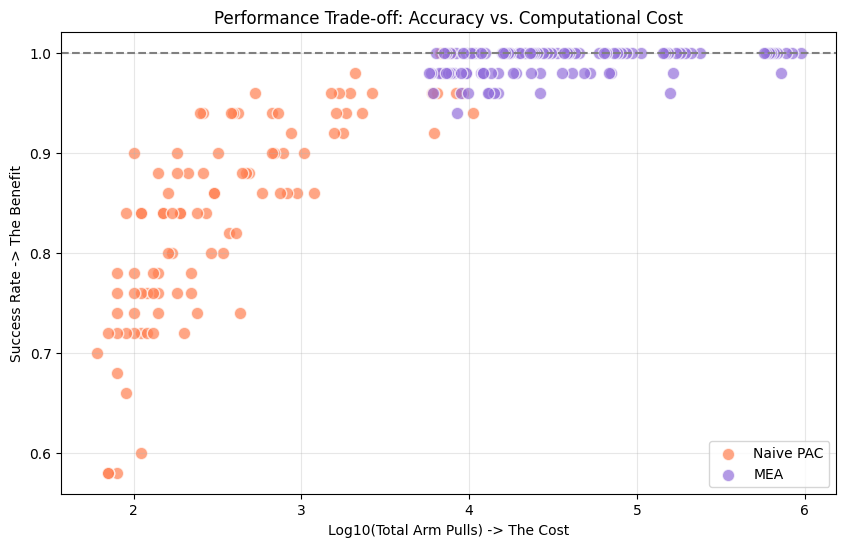

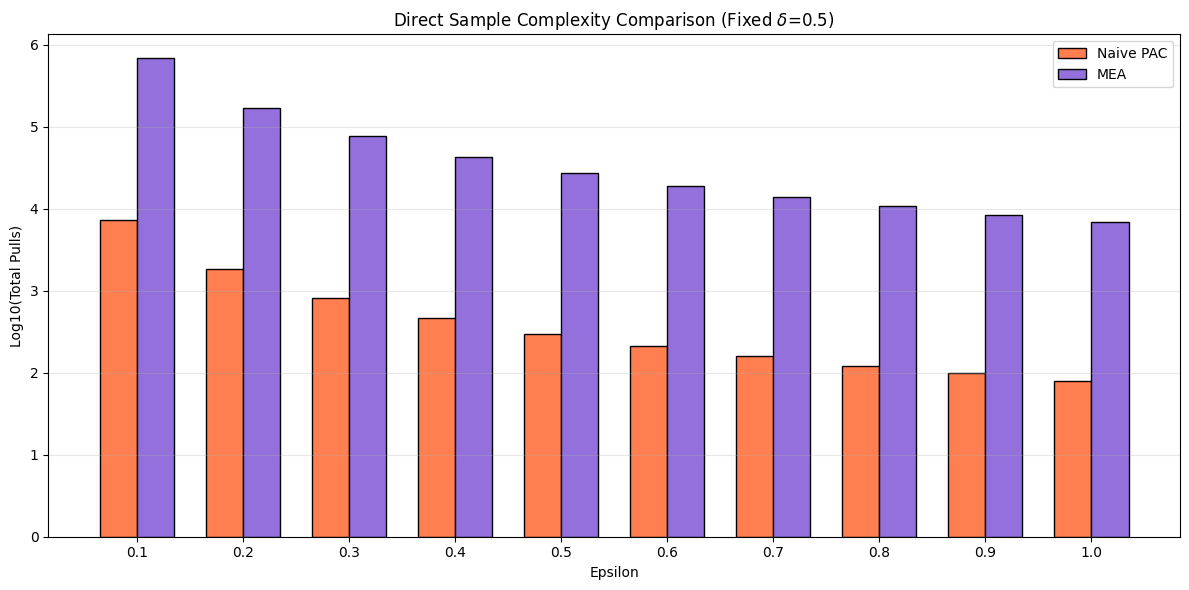

In [21]:
# ==========================================
# 3. Graph 1: 3D Surface Plots (Complexity)
# ==========================================
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(E, D, np.log10(naive_pulls), cmap='Oranges', alpha=0.9, edgecolor='k', linewidth=0.5)
ax1.set_title('Naive PAC: Log10(Sample Complexity)')
ax1.set_xlabel('Epsilon'); ax1.set_ylabel('Delta'); ax1.set_zlabel('Log10(Total Pulls)')
ax1.view_init(elev=30, azim=225) # Perfect viewing angle

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(E, D, np.log10(mea_pulls), cmap='Purples', alpha=0.9, edgecolor='k', linewidth=0.5)
ax2.set_title('MEA: Log10(Sample Complexity)')
ax2.set_xlabel('Epsilon'); ax2.set_ylabel('Delta'); ax2.set_zlabel('Log10(Total Pulls)')
ax2.view_init(elev=30, azim=225)
plt.tight_layout()
plt.show()

# ==========================================
# 4. Graph 2: Smooth Contour Plots (Accuracy)
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

c1 = axes[0].contourf(E, D, naive_succ, levels=20, cmap='RdYlGn')
axes[0].set_title('Naive PAC Success Rate Topography')
axes[0].set_xlabel('Epsilon'); axes[0].set_ylabel('Delta')
fig.colorbar(c1, ax=axes[0])

c2 = axes[1].contourf(E, D, mea_succ, levels=20, cmap='RdYlGn')
axes[1].set_title('MEA Success Rate Topography')
axes[1].set_xlabel('Epsilon'); axes[1].set_ylabel('Delta')
fig.colorbar(c2, ax=axes[1])
plt.tight_layout()
plt.show()

# ==========================================
# 5. Graph 3: Trade-Off Scatter Plot (Cost vs Benefit)
# ==========================================
plt.figure(figsize=(10, 6))
plt.scatter(np.log10(naive_pulls.flatten()), naive_succ.flatten(), alpha=0.7, s=80, c='coral', label='Naive PAC', edgecolors='white', linewidth=1)
plt.scatter(np.log10(mea_pulls.flatten()), mea_succ.flatten(), alpha=0.7, s=80, c='mediumpurple', label='MEA', edgecolors='white', linewidth=1)

plt.axhline(1.0, color='gray', linestyle='--')
plt.title('Performance Trade-off: Accuracy vs. Computational Cost')
plt.xlabel('Log10(Total Arm Pulls) -> The Cost')
plt.ylabel('Success Rate -> The Benefit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 6. Graph 4: Grouped Bar Chart (Complexity at fixed Delta)
# ==========================================
fixed_d_idx = 4 # Delta = 0.5
x = np.arange(len(eps_vals))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
# Using Log10 pulls so bars are readable
rects1 = ax.bar(x - width/2, np.log10(naive_pulls[fixed_d_idx]), width, label='Naive PAC', color='coral', edgecolor='black')
rects2 = ax.bar(x + width/2, np.log10(mea_pulls[fixed_d_idx]), width, label='MEA', color='mediumpurple', edgecolor='black')

ax.set_ylabel('Log10(Total Pulls)')
ax.set_title(f'Direct Sample Complexity Comparison (Fixed $\delta$={delta_vals[fixed_d_idx]})')
ax.set_xticks(x)
ax.set_xticklabels(eps_vals)
ax.set_xlabel('Epsilon')
ax.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()